In [ ]:
## Notebook for Deep Pilot

In [1]:
%matplotlib inline

In [7]:
import tensorflow as tf

#from scipy.misc import imread, imresize
#import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Convolution2D, Conv2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import ZeroPadding2D, Dropout, Flatten
from tensorflow.keras.layers import Reshape, Activation, BatchNormalization # removed merge DL
from tensorflow.keras.layers import concatenate
#from tensorflow.keras.utils.conv_utils import convert_kernel
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

import numpy as np
import h5py
import math

from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K 


In [59]:
def euc_lossRoll(y_true, y_pred):
    lx = K.sqrt(K.sum(K.square(y_true[:,:] - y_pred[:,:]), axis=1, keepdims=True))
    return (0.3 * lx)

def euc_lossPitch(y_true, y_pred):
    lx = K.sqrt(K.sum(K.square(y_true[:,:] - y_pred[:,:]), axis=1, keepdims=True))
    return (0.3 * lx)

def euc_lossYaw(y_true, y_pred):
    lx = K.sqrt(K.sum(K.square(y_true[:,:] - y_pred[:,:]), axis=1, keepdims=True))
    return (0.3 * lx)
    
def euc_lossAlt(y_true, y_pred):
    lx = K.sqrt(K.sum(K.square(y_true[:,:] - y_pred[:,:]), axis=1, keepdims=True))
    return (0.3 * lx)

def create_posenet_3_separated_outs(weights_path=None, tune=False):
    with tf.device('/gpu:0'):
        input = Input(shape=(224, 224, 3))
        
        conv1 = Conv2D(64,(7,7),strides=(2,2), padding='same',activation='relu',name='conv1')(input)
        pool1 = MaxPooling2D(pool_size=(3,3),strides=(2,2), padding='same',name='pool1')(conv1)
        norm1 = BatchNormalization(axis=3, name='norm1')(pool1)
        reduction2 = Conv2D(64,(1,1), padding='same',activation='relu',name='reduction2')(norm1)
        conv2 = Conv2D(192,(3,3),padding='same',activation='relu',name='conv2')(reduction2)
        norm2 = BatchNormalization(axis=3, name='norm2')(conv2)
        pool2 = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid',name='pool2')(norm2)
        icp1_reduction1 = Conv2D(96,(1,1),padding='same',activation='relu',name='icp1_reduction1')(pool2)
        icp1_out1 = Conv2D(128,(3,3),padding='same',activation='relu',name='icp1_out1')(icp1_reduction1)
        icp1_reduction2 = Conv2D(16,(1,1),padding='same',activation='relu',name='icp1_reduction2')(pool2)
        icp1_out2 = Conv2D(32,(5,5),padding='same',activation='relu',name='icp1_out2')(icp1_reduction2)
        icp1_pool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same',name='icp1_pool')(pool2)
        icp1_out3 = Conv2D(32,(1,1),padding='same',activation='relu',name='icp1_out3')(icp1_pool)
        icp1_out0 = Conv2D(64,(1,1),padding='same',activation='relu',name='icp1_out0')(pool2)
        icp2_in = concatenate([icp1_out0, icp1_out1, icp1_out2, icp1_out3], axis=-1)

        icp2_reduction1 = Conv2D(128,(1,1),padding='same',activation='relu',name='icp2_reduction1')(icp2_in)
        icp2_out1 = Conv2D(192,(3,3),padding='same',activation='relu',name='icp2_out1')(icp2_reduction1)
        icp2_reduction2 = Conv2D(32,(1,1),padding='same',activation='relu',name='icp2_reduction2')(icp2_in)
        icp2_out2 = Conv2D(96,(5,5),padding='same',activation='relu',name='icp2_out2')(icp2_reduction2)
        icp2_pool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same',name='icp2_pool')(icp2_in)
        icp2_out3 = Conv2D(64,(1,1),padding='same',activation='relu',name='icp2_out3')(icp2_pool)
        icp2_out0 = Conv2D(128,(1,1),padding='same',activation='relu',name='icp2_out0')(icp2_in)
        icp2_out = concatenate([icp2_out0, icp2_out1, icp2_out2, icp2_out3], axis=-1)

        icp3_in = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same',name='icp3_in')(icp2_out)
        icp3_reduction1 = Conv2D(96,(1,1),padding='same',activation='relu',name='icp3_reduction1')(icp3_in)
        icp3_out1 = Conv2D(208,(3,3),padding='same',activation='relu',name='icp3_out1')(icp3_reduction1)
        icp3_reduction2 = Conv2D(16,(1,1),padding='same',activation='relu',name='icp3_reduction2')(icp3_in)
        icp3_out2 = Conv2D(48,(5,5),padding='same',activation='relu',name='icp3_out2')(icp3_reduction2)
        icp3_pool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same',name='icp3_pool')(icp3_in)
        icp3_out3 = Conv2D(64,(1,1),padding='same',activation='relu',name='icp3_out3')(icp3_pool)
        icp3_out0 = Conv2D(192,(1,1),padding='same',activation='relu',name='icp3_out0')(icp3_in)
        icp3_out = concatenate([icp3_out0, icp3_out1, icp3_out2, icp3_out3], axis = -1)

        cls1_pool = AveragePooling2D(pool_size=(5,5),strides=(3,3),padding='valid',name='cls1_pool')(icp3_out)
        cls1_reduction_speed = Conv2D(128,(1,1),padding='same',activation='relu',name='cls1_reduction_speed')(cls1_pool)
        cls1_fc1_flat = Flatten()(cls1_reduction_speed)    

        # Dedicate dense layer for each axis
        cls1_branch1_speed = Dense(1024,activation='relu',name='cls1_branch1_speed')(cls1_fc1_flat)
        cls1_branch2_speed = Dense(1024,activation='relu',name='cls1_branch2_speed')(cls1_fc1_flat)
        cls1_branch3_speed = Dense(1024,activation='relu',name='cls1_branch3_speed')(cls1_fc1_flat)
        cls1_branch4_speed = Dense(1024,activation='relu',name='cls1_branch4_speed')(cls1_fc1_flat)

        # Layer for each axis (1 neuron layer)
        roll = Dense(1,name='roll')(cls1_branch1_speed)
        pitch = Dense(1,name='pitch')(cls1_branch2_speed)
        yaw = Dense(1,name='yaw')(cls1_branch3_speed)
        altitude = Dense(1,name='altitude')(cls1_branch4_speed)
        
        posenet = Model(inputs=input, outputs=[roll, pitch, yaw, altitude])

    if tune:
        if weights_path:
            weights_data = np.load(weights_path, allow_pickle = True, encoding='latin1').item()
            for layer in posenet.layers:
                if layer.name in weights_data.keys():
                    layer_weights = weights_data[layer.name]
                    layer.set_weights((layer_weights['weights'], layer_weights['biases']))
            print("FINISHED SETTING THE WEIGHTS!")
    return posenet


In [60]:
from tqdm import tqdm
import numpy as np
import os.path
import sys
import random
import math
import cv2
import gc

In [74]:
directory = '/Users/debbieliske/Documents/Coding Projects/Deep Pilot/mosaics_4img/'
#directory = './mosaics-4img/'
# dataset_train = 'train/train.txt'
# dataset_test = 'test/test.txt'

dataset_train = 'mosaic-4img-Train_v3.txt'
dataset_test = 'mosaic-4img-Validation_v3.txt'


class datasource(object):
    def __init__(self, images, speed):
        self.images = images
        self.speed = speed

def preprocess(images):
    images_out = [] #final result
    #Resize input images
    for i in tqdm(range(len(images))):
        # DL !!!
        #print(images[i])
        X = cv2.imread(images[i])
        if X is not None: # DL !!!
            #print("HERE", X.shape)
            X = cv2.resize(X, (224, 224))
            X = np.transpose(X,(2,0,1))
            X = np.squeeze(X)
            X = np.transpose(X, (1,2,0))
            Y = np.expand_dims(X, axis=0)
            images_out.append(Y)
    del X, i
    gc.collect()
    return images_out

def preprocess_2(image):
    images_out = [] #final result

    X = cv2.resize(image, (224, 224))
    N = 1
    mean = np.zeros((1, 3, 224, 224))
    X = np.transpose(X,(2,0,1))
    X = X - mean
    X = np.squeeze(X)
    X = np.transpose(X, (1,2,0))
    Y = np.expand_dims(X, axis=0)
    images_out.append(Y)
    return images_out

def get_data(dataset):
    speed = []
    images = []
    print(directory+dataset)
    with open(directory+dataset) as f:
        print(f)
        next(f)  # skip the header line
        next(f)
        next(f)
        for line in f:
            #fname,p0,p1,p2,p3 = line.split(',')
            fname,p0,p1,p2,p3 = line.split()
            p0 = float(p0)
            p1 = float(p1)
            p2 = float(p2)
            p3 = float(p3)
            speed.append((p0,p1,p2,p3))
            #print("HERERERERE", fname)
            images.append(directory+fname)
    images_out = preprocess(images)
    return datasource(images_out, speed)

#def get_data2(dataset):



def getTrainSource():
    datasource_train = get_data(dataset_train)
    datasource_test = get_data(dataset_test)
   
    images_train = []
    speed_train = []

    images_test = []
    speed_test = []

    for i in range(len(datasource_train.images)):
        images_train.append(datasource_train.images[i])
        speed_train.append(datasource_train.speed[i])
    for i in range(len(datasource_test.images)):
        images_test.append(datasource_test.images[i])
        speed_test.append(datasource_test.speed[i])

    return datasource(images_train, speed_train), datasource(images_test, speed_test)

def getTestSource():
    datasource_test = get_data(dataset_test)

    images_test = []
    speed_test = []

    for i in range(len(datasource_test.images)):
        images_test.append(datasource_test.images[i])
        speed_test.append(datasource_test.speed[i])

    return datasource(images_test, speed_test)	


FINISHED SETTING THE WEIGHTS!
/Users/debbieliske/Documents/Coding Projects/Deep Pilot/mosaics_4img/mosaic-4img-Train_v3.txt
<_io.TextIOWrapper name='/Users/debbieliske/Documents/Coding Projects/Deep Pilot/mosaics_4img/mosaic-4img-Train_v3.txt' mode='r' encoding='UTF-8'>


100%|██████████████████████████████████████| 9964/9964 [00:32<00:00, 304.22it/s]


/Users/debbieliske/Documents/Coding Projects/Deep Pilot/mosaics_4img/mosaic-4img-Validation_v3.txt
<_io.TextIOWrapper name='/Users/debbieliske/Documents/Coding Projects/Deep Pilot/mosaics_4img/mosaic-4img-Validation_v3.txt' mode='r' encoding='UTF-8'>


100%|██████████████████████████████████████| 2753/2753 [00:05<00:00, 486.68it/s]
2022-04-09 11:54:42.892268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-09 11:55:02.994492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.14489, saving model to ./models/test.h5

Epoch 00002: val_loss improved from 0.14489 to 0.12629, saving model to ./models/test.h5

Epoch 00003: val_loss improved from 0.12629 to 0.11784, saving model to ./models/test.h5

Epoch 00004: val_loss improved from 0.11784 to 0.11431, saving model to ./models/test.h5

Epoch 00005: val_loss improved from 0.11431 to 0.11222, saving model to ./models/test.h5

Epoch 00006: val_loss did not improve from 0.11222

Epoch 00007: val_loss did not improve from 0.11222

Epoch 00008: val_loss did not improve from 0.11222

Epoch 00009: val_loss did not improve from 0.11222

Epoch 00010: val_loss did not improve from 0.11222


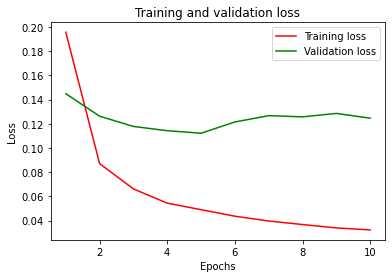

In [75]:

#if __name__ == "__main__":
K.clear_session()
# Variables
#change batch_size in function of your VRAM capacity, or for the sample size you want
batch_size = 32
epochs = 10

# Train model
# Model creation for separated outputs
#model = net.create_posenet_3_separated_outs('posenet.npy', True) # GoogLeNet (Trained on Places)
model = create_posenet_3_separated_outs('models/posenet.npy', True) # GoogLeNet (Trained on Places)
#model = create_posenet_3_separated_outs(None, True) 



adam = Adam(lr=0.001, clipvalue=1.5)

#Same compilation for both nets, dense layers have sema name.
# model.compile(optimizer=adam, loss={'roll': net.euc_lossRoll,
#                                     'pitch': net.euc_lossPitch,
#                                     'yaw': net.euc_lossYaw, 
#                                     'altitude': net.euc_lossAlt})
model.compile(optimizer=adam, loss={'roll': euc_lossRoll,
                                    'pitch': euc_lossPitch,
                                    'yaw': euc_lossYaw, 
                                    'altitude': euc_lossAlt})



#dataset_train, dataset_test = helper_net.getTrainSource()
dataset_train, dataset_test = getTrainSource()

X_train = np.squeeze(np.array(dataset_train.images))
y_train = np.squeeze(np.array(dataset_train.speed))

y_train_roll = y_train[:,0:1]
y_train_pitch = y_train[:,1:2]
y_train_yaw = y_train[:,2:3]
y_train_altitude = y_train[:,3:4]

X_test = np.squeeze(np.array(dataset_test.images))
y_test = np.squeeze(np.array(dataset_test.speed))

y_test_roll = y_test[:,0:1]
y_test_pitch = y_test[:,1:2]
y_test_yaw = y_test[:,2:3]
y_test_altitude = y_test[:,3:4]

# Setup checkpointing
#file_name.h5 -> the file where to save data
#save_best_only -> not to save all the weights just the ones who improves
#save_weights_only -> if true save the weights, if false save the entire model +  weights
checkpointer = ModelCheckpoint(filepath="./models/test.h5", verbose=4, save_best_only=True, save_weights_only=False)

#In this part you specify the labels for training learning and for validation
history = model.fit(X_train, [y_train_roll, y_train_pitch, y_train_yaw, y_train_altitude],
      batch_size=batch_size,
      epochs=epochs,
      verbose=0,
      validation_data=(X_test, [y_test_roll, y_test_pitch, y_test_yaw, y_test_altitude]),
      callbacks=[checkpointer])


#if you save only weghts true in checkpointer, this in redundant, but if is false, and 
#want to have separete weights, uncomment this line.
model.save_weights("./models/test_weights.h5")


#For plot the training and validation losses 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


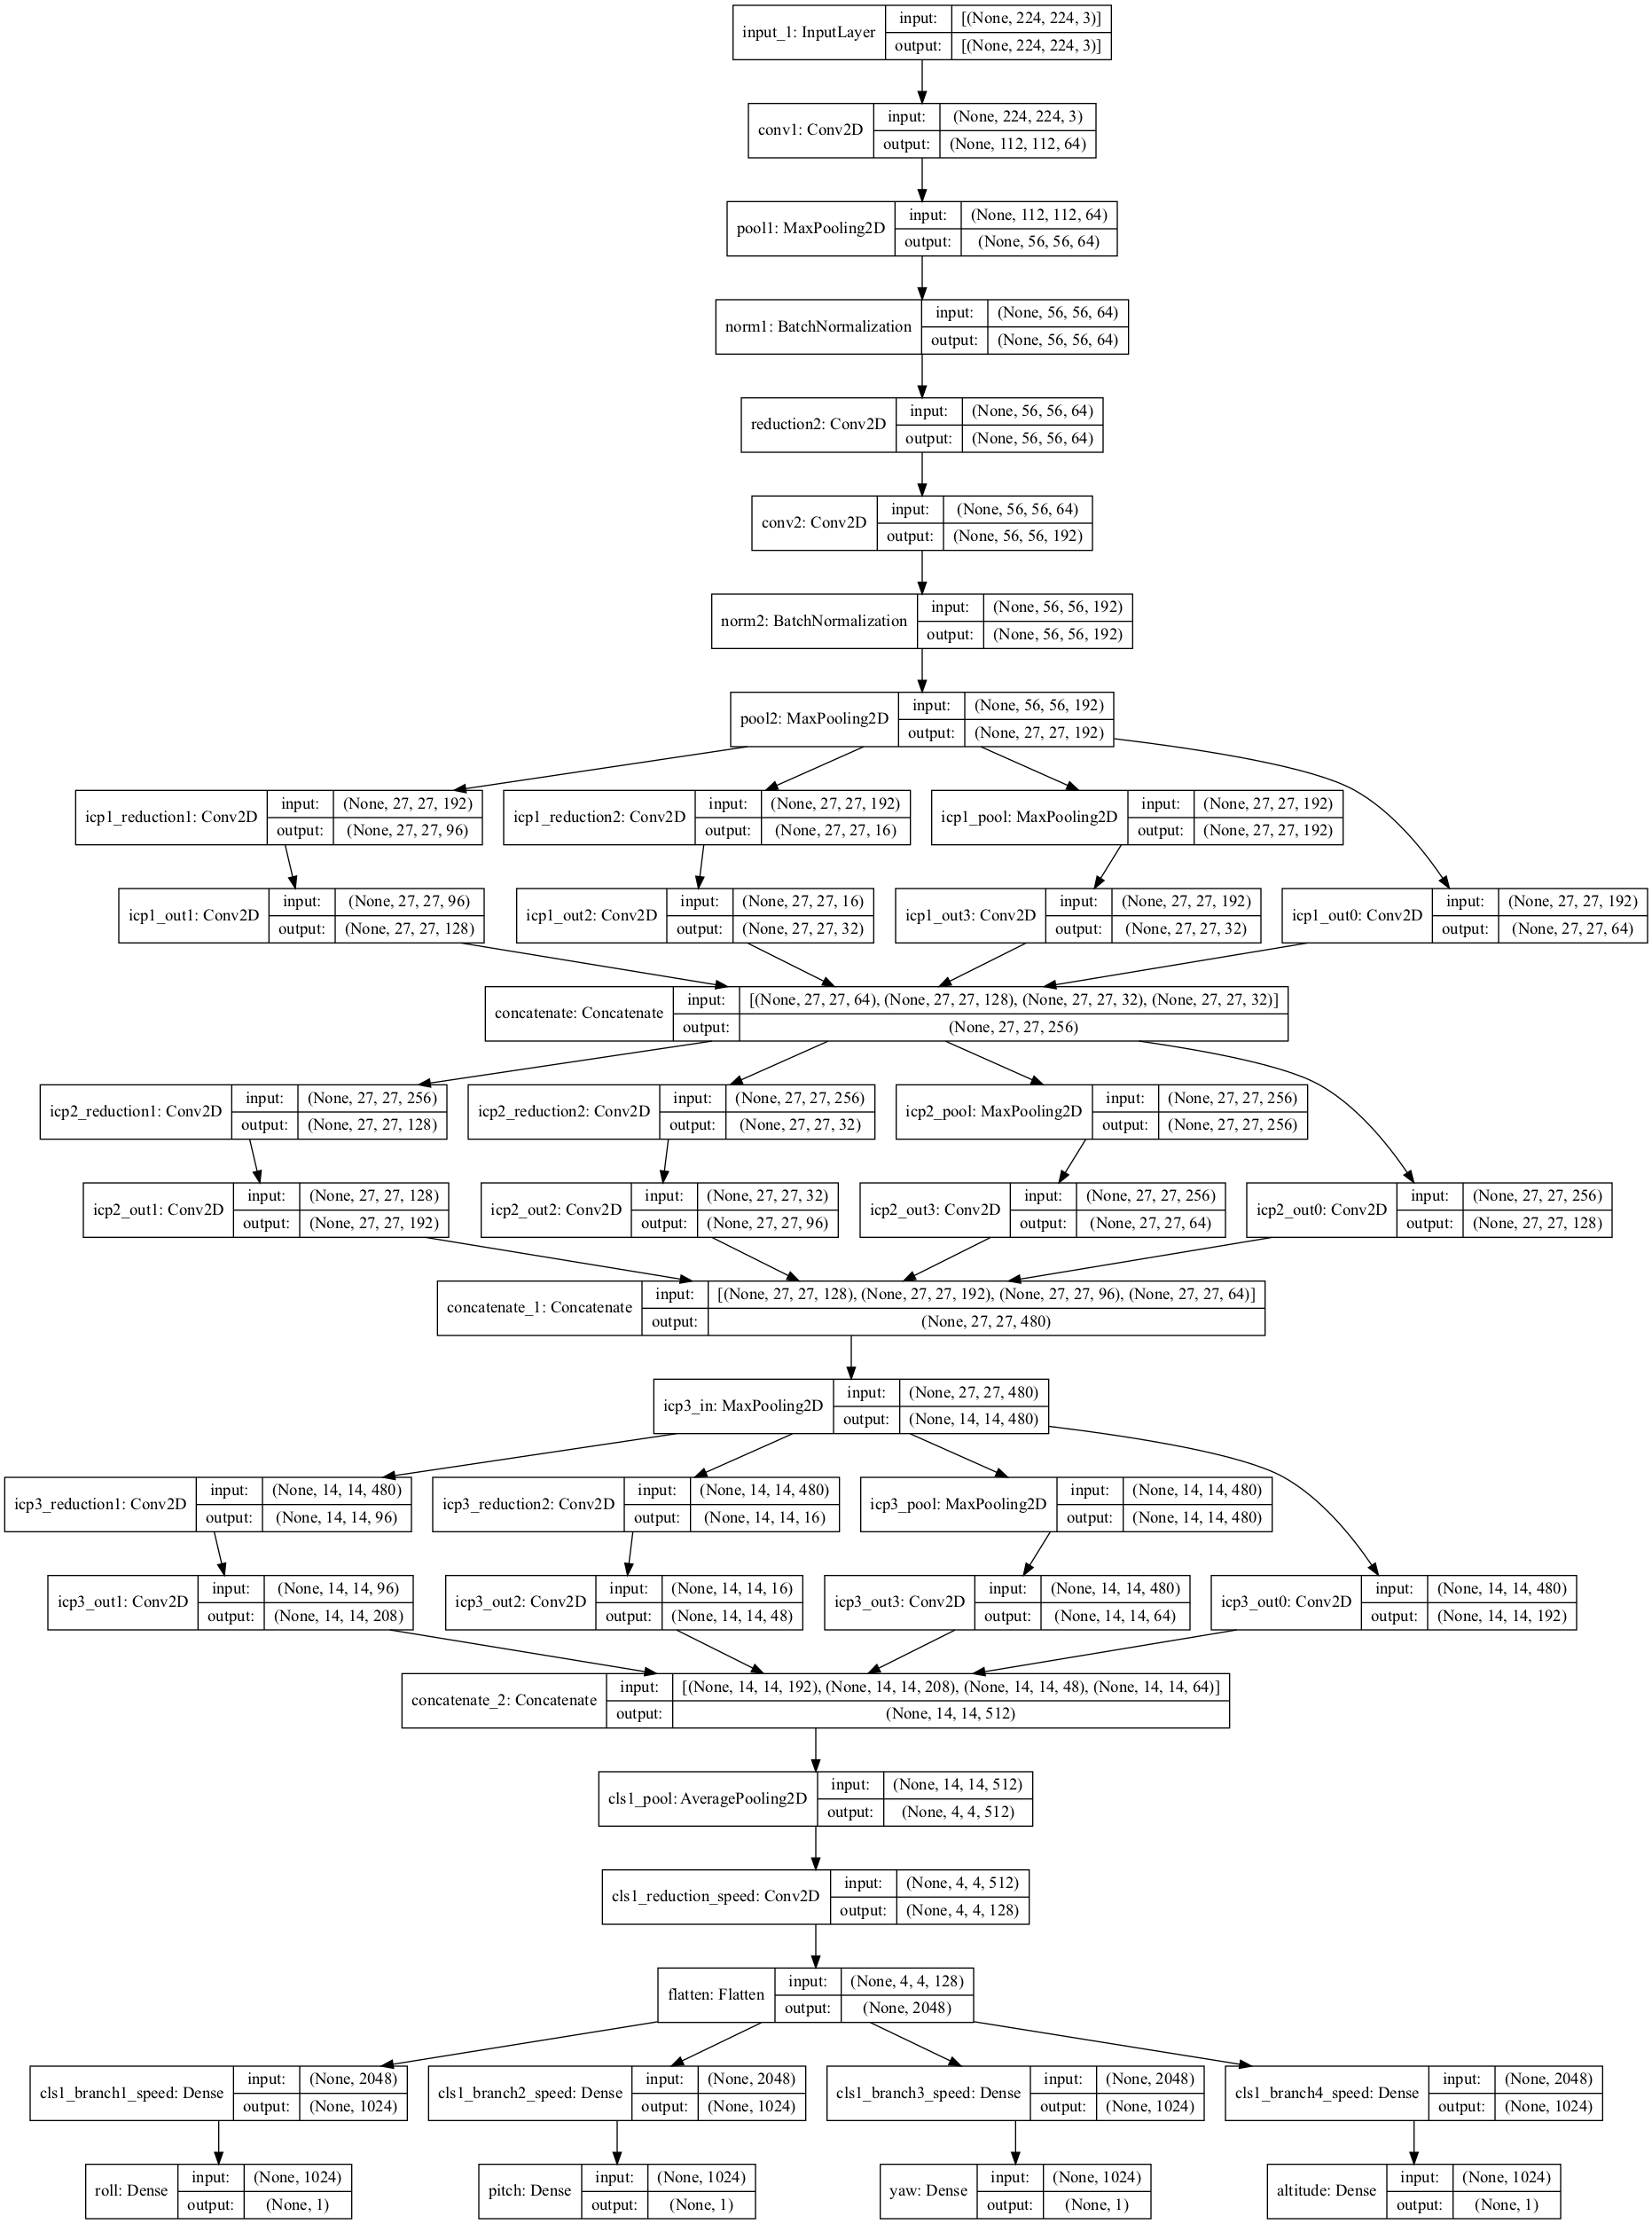

In [80]:
filename = 'model_plot.png'
plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(filename)